# Table of Contents

### [Introduction](#tag1)

### [Daily sales of events by category](#tag2)

### [Event sale vs non-event day sale: Labor day oversales🛠](#tag3)

### [Event and product categories: big sports holidays are all about food🏈🍕](#tag4)

### More to come..


## <a id=tag1>Introduction</a>

A few notebooks here discussed about the effect of SNAP (Supplemental Nutrition Assistance Program) days, but I am particularly interested in the effect of **events & festivities**. So here is a series of visualization...

In [1]:
## librarary
!pip install calmap
import os
import pandas as pd
import plotly.express as px
#os.listdir('../m5-forecasting-uncertainty/')

import seaborn as sns

import numpy as np; np.random.seed(sum(map(ord, 'calmap')))
import pandas as pd
import calmap
import matplotlib.pyplot as plt
import math

calendar= pd.read_csv('../input/m5-forecasting-accuracy/calendar.csv')
sell_prices = pd.read_csv('../input/m5-forecasting-accuracy/sell_prices.csv')
sales = pd.read_csv('../input/m5-forecasting-accuracy/sales_train_validation.csv')

Here are all the names of festivals:

In [2]:
calendar.event_name_1.unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

In [3]:
calendar.event_name_2.unique()

array([nan, 'Easter', 'Cinco De Mayo', 'OrthodoxEaster', "Father's day"],
      dtype=object)

There are four types of festivals: **National, Religious, Sporting and Cultural**. Below is a calendar view all the events. 

In [4]:
calendar['event_true_1'] = calendar.event_name_1.notna()
calendar['event_true_2'] = calendar.event_name_2.notna()

calendar['event_true_all'] = calendar.event_true_1 + calendar.event_true_2
calendar['event_true_all'] = calendar.event_true_all.apply(lambda x: x>0)
calendar['event_true_all'] = calendar.event_true_all.astype('int')
calendar['date'] = pd.to_datetime(calendar.date)

events_series = pd.Series(calendar.event_true_all.values, index=calendar.date)

/opt/conda/lib/python3.6/site-packages/pandas/core/computation/expressions.py:194: UserWarning:

evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead



In [5]:
calendar['event_name_all'] = calendar.event_name_1.fillna('') + '_' +calendar.event_name_2.fillna('')
calendar['event_name_all'] = calendar.event_name_all.apply(lambda x: x[:-1] if x[len(x)-1] == '_' else x)

/opt/conda/lib/python3.6/site-packages/calmap/__init__.py:221: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.



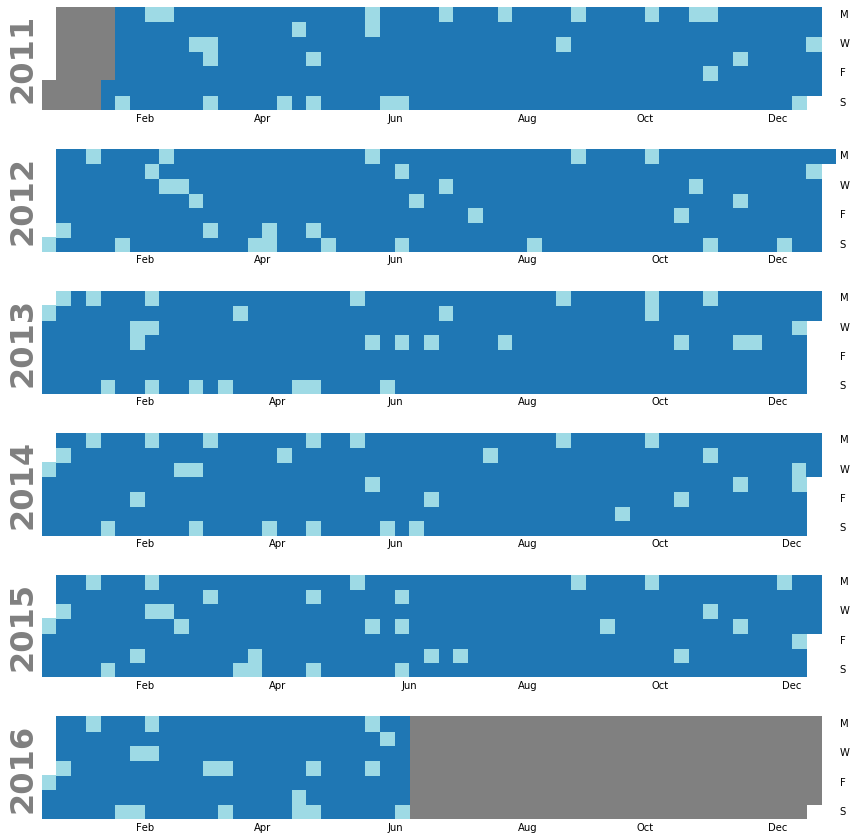

In [6]:
calmap.calendarplot(events_series, monthticks=2, daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6], cmap='tab20',
                    fillcolor='grey', linewidth=0,
                    fig_kws=dict(figsize=(12, 12)))
plt.show()

## <a id=tag2>Daily sales on events by category (TOP10) </a>

In [7]:
d_list = calendar[calendar.event_true_all==1].d.values
year_list = calendar[calendar.event_true_all == 1].year.values
name_list = calendar[calendar.event_true_all == 1].event_name_all

barplot_pd = pd.DataFrame({'Year': year_list, 'd': d_list, 'Name': name_list}).reset_index()

In [8]:
barplot_pd=barplot_pd[:154]

In [9]:
def get_daily_average(d, dep):
    return sales[sales.dept_id==dep][d].mean()

In [10]:
for dept in sales.dept_id.unique():
    barplot_pd[dept] = barplot_pd.d.apply(lambda x: get_daily_average(x, dept))

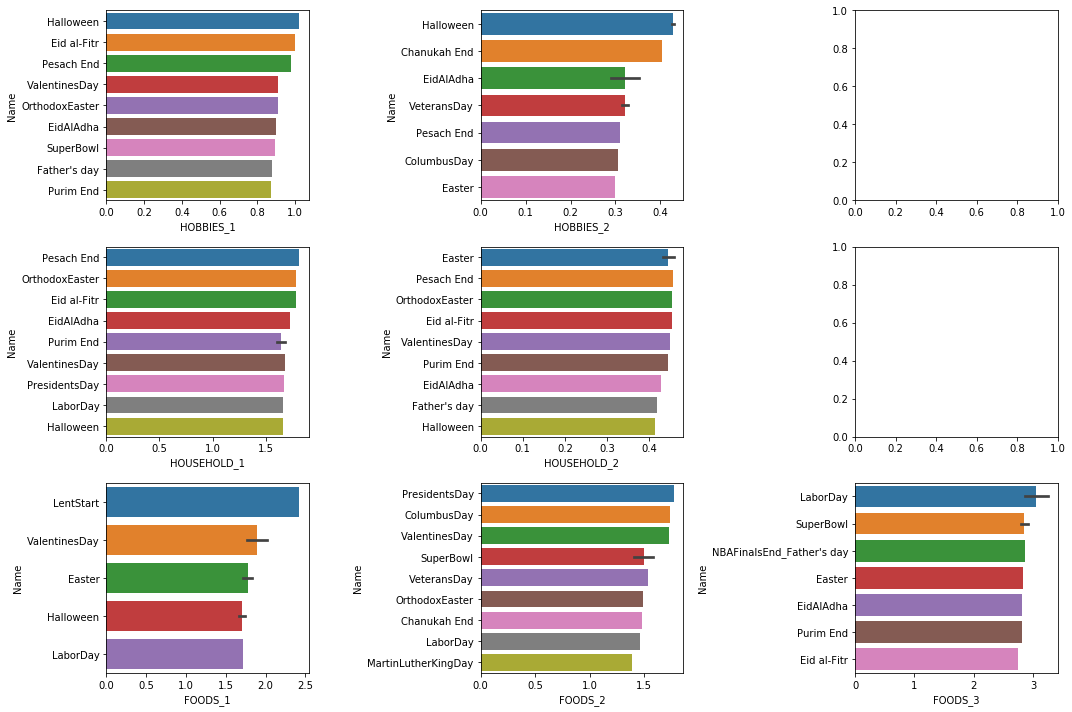

In [11]:

f, axes = plt.subplots(3,3, figsize=(15,10))

barplot_pd = barplot_pd.sort_values('HOBBIES_1', ascending=False)
sns.barplot(barplot_pd.HOBBIES_1[:10], barplot_pd.Name[:10], ax=axes[0,0])
barplot_pd = barplot_pd.sort_values('HOBBIES_2', ascending=False)
sns.barplot(barplot_pd.HOBBIES_2[:10], barplot_pd.Name[:10], ax=axes[0,1])
barplot_pd = barplot_pd.sort_values('HOUSEHOLD_1', ascending=False)
sns.barplot(barplot_pd.HOUSEHOLD_1[:10], barplot_pd.Name[:10], ax=axes[1,0])
barplot_pd = barplot_pd.sort_values('HOUSEHOLD_2', ascending=False)
sns.barplot(barplot_pd.HOUSEHOLD_2[:10], barplot_pd.Name[:10], ax=axes[1,1])
barplot_pd = barplot_pd.sort_values('FOODS_1', ascending=False)
sns.barplot(barplot_pd.FOODS_1[:10], barplot_pd.Name[:10], ax=axes[2,0])
barplot_pd = barplot_pd.sort_values('FOODS_2', ascending=False)
sns.barplot(barplot_pd.FOODS_2[:10], barplot_pd.Name[:10], ax=axes[2,1])
barplot_pd = barplot_pd.sort_values('FOODS_3', ascending=False)
sns.barplot(barplot_pd.FOODS_3[:10], barplot_pd.Name[:10], ax=axes[2,2])
plt.tight_layout()

Halloween has the highest amount of sales in HOBBIES category; Lent Start wins in the FOODS_1 category. I am curious about what kind of goods in FOODS_2 category; why Presidents day and Columbus day on this list?

## <a id=tag3>Events vs non events total sales</a>


Here I used a ratio beween event sales and average daily sales as a indicator of 'holiday effect'. If the ratio > 1, that means people buy more during holidays than usual. It turns out **Labor day oversales the most.  **

$$holiday\,  effect = \frac{holiday\,  average \, sale}{non-holiday\,  average \, sale} $$

In [12]:
group_calendar = calendar[calendar.date < pd.datetime(2016, 4, 25)].groupby(['year', 'event_true_all', 'event_name_all'])\
.agg({'d': lambda x: list(x)})\
.reset_index()

In [13]:
def get_avg_year_value(d_list):
    my_dict = dict((d,'mean') for d in d_list)
    all_means = sales.groupby('cat_id').agg(my_dict).values
    return all_means.mean()

In [14]:
group_calendar['avg_sale_unit'] = group_calendar.d.apply(lambda x: get_avg_year_value(x))

In [15]:
joined_group_calendar = \
group_calendar[group_calendar.event_true_all==1]\
.merge(group_calendar[group_calendar.event_true_all==0][['year', 'avg_sale_unit']]\
.rename({'avg_sale_unit': 'non_event_avg_sale_unit'}, axis=1), on='year')

In [16]:
joined_group_calendar['ratio'] = joined_group_calendar.avg_sale_unit / joined_group_calendar.non_event_avg_sale_unit

In [17]:
plt.style.use('ggplot')
plot_pd_1 = joined_group_calendar\
.groupby('event_name_all').agg({'ratio': 'mean'}, axis=1).sort_values('ratio', ascending=False)



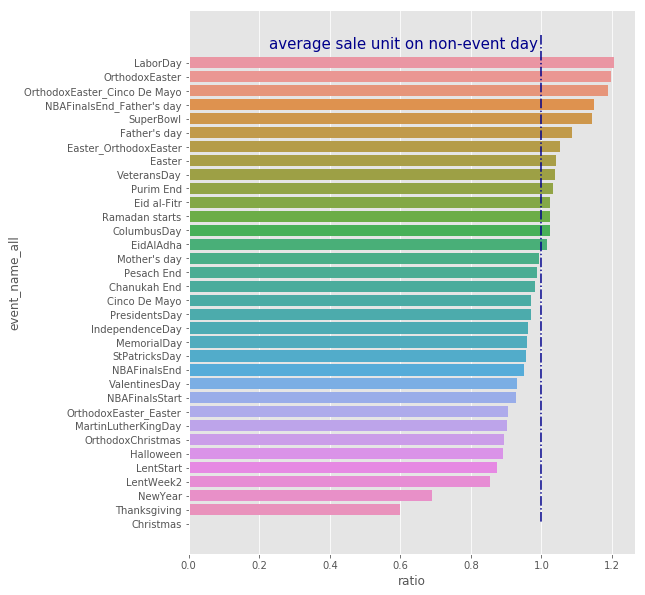

In [18]:
plt.figure(figsize=(8,10))
sns.barplot(x=plot_pd_1.ratio, y=plot_pd_1.index)
plt.vlines(x=1, ymin=-2, ymax=33, linestyles='-.', color='darkblue')
plt.text(0.99, -0.8, 'average sale unit on non-event day',
        verticalalignment='bottom', horizontalalignment='right',
        color='darkblue', fontsize=15)
plt.show()

## <a id=tag4> Events & associated categories </a>

Below are 3-D and 2-D scatterplot where each event category is mapped on the 'holiday effect' ratio indicator. It is hard to get a clear separation on the 3-d plot, except the fact that **sales decreases a lot during big holidays (christmas, thanksgiving and new year)**

In [19]:
def get_avg_category(d_list, category):
    my_dict = dict((d,'mean') for d in d_list)
    all_means = sales.groupby('cat_id').agg(my_dict).mean(axis=1)[category]
    return all_means

In [20]:
for category in sales.cat_id.unique():
    group_calendar[category] = group_calendar['d'].apply(lambda x: get_avg_category(x, category))
    

In [21]:
plot_pd_2 = group_calendar.groupby('event_name_all')\
.agg({'HOBBIES':'mean', 'HOUSEHOLD':'mean', 'FOODS': 'mean'}).reset_index()

In [22]:
plot_pd_2 = plot_pd_2.merge(calendar[['event_name_all', 'event_type_1']], on='event_name_all', how='left')\
.drop_duplicates().dropna()

In [23]:


fig = px.scatter_3d(plot_pd_2, x='HOUSEHOLD', y='FOODS', z='HOBBIES',
              color='event_type_1', hover_data=['event_name_all'])
fig.update_layout(margin=dict(l=1, r=1, b=1, t=1))
fig.show()

In [24]:
fig = px.scatter(plot_pd_2, x="FOODS", y="HOBBIES", color='event_type_1', \
                 size=[0.1]*34)
fig.show()

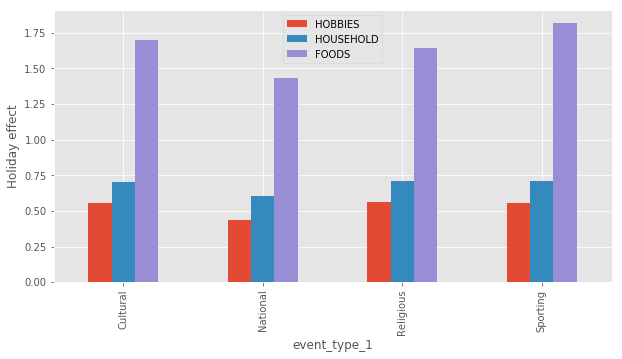

In [25]:
plot_pd_2.groupby('event_type_1').mean().plot.bar(figsize=(10,5))
plt.ylabel('Holiday effect')
plt.show()

This shows that the patterns for different holidays are similar; **Food is the theme of holidays, especially for sporting events**